In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import torch
import anytree

import sys, os
#np.set_printoptions(suppress=True, precision=40)

import math

In [2]:
def compute_local_cost(pi, a, dx, b, dy, eps, rho, rho2, complete_cost=True):
    """
    Author: Thibault Séjourné <https://github.com/thibsej/unbalanced_gromov_wasserstein>
    
    Compute the local cost by averaging the distortion with the current
    transport plan.

    Parameters
    ----------
    pi: torch.Tensor of size [Batch, size_X, size_Y]
    transport plan used to compute local cost

    a: torch.Tensor of size [Batch, size_X]
    Input measure of the first mm-space.

    dx: torch.Tensor of size [Batch, size_X, size_X]
    Input metric of the first mm-space.

    b: torch.Tensor of size [Batch, size_Y]
    Input measure of the second mm-space.

    dy: torch.Tensor of size [Batch, size_Y, size_Y]
    Input metric of the second mm-space.

    eps: float
    Strength of entropic regularization.

    rho: float
    Strength of penalty on the first marginal of pi.

    rho2: float
    Strength of penalty on the first marginal of pi. If set to None it is
    equal to rho.

    complete_cost: bool
    If set to True, computes the full local cost, otherwise it computes the
    cross-part on (X,Y) to reduce computational complexity.

    Returns
    ----------
    lcost: torch.Tensor of size [Batch, size_X, size_Y]
    local cost depending on the current transport plan.
    """
    tmp = np.ones(np.shape(pi)[0])
    leb1 = tmp / np.sum(tmp)
    tmp = np.ones(np.shape(pi)[1])
    leb2 = tmp / np.sum(tmp)
    distxy = torch.einsum(
        "ij,kj->ik", dx, torch.einsum("kl,jl->kj", dy, pi)
    )
    kl_pi = torch.sum(
        pi * (pi / (leb1[:, None] * leb2[None, :]) + 1e-10).log()
    )
    #print(kl_pi)
    #kl_pi = 0
    if not complete_cost:
        return - 2 * distxy + eps * kl_pi

    mu, nu = torch.sum(pi, dim=1), torch.sum(pi, dim=0)
    distxx = torch.einsum("ij,j->i", dx ** 2, mu)
    distyy = torch.einsum("kl,l->k", dy ** 2, nu)

    lcost = (distxx[:, None] + distyy[None, :] - 2 * distxy) #+ eps * kl_pi

    if rho < float("Inf") and rho > 0:
        lcost = (
                lcost
                + rho
                * torch.sum(mu * (mu / a + 1e-10).log())
        )
    if rho2 < float("Inf") and rho2 > 0:
        lcost = (
                lcost
                + rho2
                * torch.sum(nu * (nu / b + 1e-10).log())
        )
    return lcost


In [3]:
def tree_sinkhorn_sep(root, eps, rho,
    divergence='KL',
    max_iter=10000,
    cvgce_thres=1e-5, 
    n_its_check_cvgce=10,
    pot_large=1e10,
    verbose=False):

    assert divergence in ['KL', 'TV'], "unknown divergence"

    # init tree
    assert hasattr(root, 'mu'), "root node needs to be a node with given measure mu or domain_shape must be given"
    #lebesgue = np.ones(domain_shape) / np.prod(domain_shape)
    forward = [node for node in anytree.PreOrderIter(root)]
    backward = forward[::-1]
    for node in forward:
        assert hasattr(node, 'cost')
        node.given = (hasattr(node, 'mu'))
        if node.cost is not None:
            node.domain_shape = len(node.cost.T)
        else:
            node.domain_shape = len(node.mu)
        if node.given:
            node.u = np.ones(node.domain_shape)
        else:
            node.u = [np.ones(node.domain_shape) for _ in range(node.n_labels)]
        node.K = [] if node.is_root else np.exp(-node.cost/eps)
        node.a_forw = [np.ones(node.domain_shape) for _ in range(node.n_labels)]
        if not node.is_root:
            node.a_backw = [np.ones(node.parent.domain_shape) for _ in range(node.n_labels)]
        node.marginal = None
        node.pi_left = None
        node.pi_right = None
        if rho is not None:
            node.rho = rho
        node.exponent = node.rho/(node.rho+eps) if not np.isinf(node.rho) else 1.0

    # init iterations
    update = np.inf
    it = 0
    memsnapit = 10
    #     tracemalloc.start(1000)
    prevru = None
    prevn2u = None
    mid = forward[1]
    # unbalanced multi-sinkhorn iterations
    while (update > cvgce_thres and it < max_iter):
        del prevru
        del prevn2u
        prevru = deepcopy(r.u)
        prevn2u = deepcopy(r.children[0].children[0].u)
        # forward pass: update scaling variables u and then update alphas in
        # direction from root down towards leaves simultaneously
        for node in forward:
            if node.given:
                incoming = [np.sum(child.a_backw,axis=0) for child in node.children] + ([] if node.is_root else [np.sum(node.a_forw,axis=0)])
            else:
                incoming = [child.a_backw for child in node.children] + ([] if node.is_root else [node.a_forw])
            if node.given:
                if node.exponent == 0:#
                    node.u = np.ones(np.shape(node.u))#
                elif divergence == 'KL':
                    node.u = (node.mu / np.prod(incoming,axis=0))**node.exponent #*node.itermult
                elif divergence == 'TV':
                    print("TV NOT IMPLEMENTED YET")
                    node.u = np.minimum(np.exp((rho+0)/eps), np.maximum(np.exp(-(rho+0)/eps), node.mu/np.prod(incoming, axis=0)))
            for i, child in enumerate(node.children):
                #print("node.id:" + str(node.id) + ", child.id:" + str(child.id))
                incoming = np.array(incoming)
                if node.given:
                    a_prod = np.prod(list(incoming[:i]) + list(incoming[i+1:]), axis=0)
                    #assume child is not given:
                    child.a_forw = np.array([child.K[l].T.dot(node.u*a_prod) for l in range(node.n_labels)])
                else:
                    if i == 0:
                        a_prod = incoming[i+1:][0]
                    #assume child is given
                    child.a_forw = np.array([child.K[l].T.dot(node.u[l]*a_prod[l]) for l in range(node.n_labels)])
                
        # backward pass: update alphas in direction from leaves up towards root
        for node in backward[:-1]: # everyone except root
            a_prod = np.array([np.prod([child.a_backw[l] for child in node.children], axis=0) for l in range(node.n_labels)])
            if node.given:
                a_prod = 1
                node.a_backw = [node.K[l].dot(node.u*a_prod) for l in range(node.n_labels)]
            else:
                a_prod = [np.prod([child.a_backw[l] for child in node.children], axis=0) for l in range(node.n_labels)]
                node.a_backw = [node.K[l].dot(node.u[l]*a_prod[l]) for l in range(node.n_labels)]

        it += 1

        # compute updates every couple iterations
        if it % n_its_check_cvgce == 0:
            abs_err = np.max([np.max(np.abs(r.u - prevru)),np.max(np.abs(r.children[0].children[0].u - prevn2u))])
            update = abs_err / max(1., r.u.max(), prevru.max(), r.children[0].children[0].u.max(), prevn2u.max())
            
            if verbose >= 2:
                print("-----it {0}, update {1}".format(it, update))
            #if np.isinf(update):
            #    print("Algorithm diverged. Return None.")
                #return None

    # compute marginals and marginal plans
    for node in forward:
        if node.given:
            incoming = [np.sum(child.a_backw,axis=0) for child in node.children] + ([] if node.is_root else [np.sum(node.a_forw,axis=0)])
            node.marginal = node.u * np.prod(incoming, axis=0)
        else:
            incoming = np.array([np.array([child.a_backw[l] for child in node.children] + [node.a_forw[l]]) for l in range(node.n_labels)])           
            node.marginal = np.array([node.u[l] * np.prod(incoming[l], axis=0) for l in range(node.n_labels)])
        #node.marginal = node.u * np.prod(incoming, axis=0)
        if not node.is_root:
            parent_in = [([] if node.parent.is_root else [node.parent.a_forw[l]]) \
                        + [child.a_backw[l] for child in node.parent.children if child != node] for l in range(node.n_labels)] # first line: from parent's parent, second line: from parents children except node

            if node.given:
                node.pi_left = node.parent.u * node.parent.a_forw
                node.pi_right = node.u
                node.pi = np.array([node.pi_left[l][:, None] * node.K[l] * node.pi_right[None, :] for l in range(node.n_labels)]) #/ node.marginal
            else:
                node.pi_left = node.parent.u
                node.pi_right = np.array(node.u) * np.array(node.children[0].a_backw)
                node.pi = np.array([node.pi_left[:, None] * node.K[l] * node.pi_right[l][None, :] for l in range(node.n_labels)]) #/ node.marginal
                     

    #print("Terminated after {0} iterations with last update {1}.".format(it, update))
    return root

In [4]:
def MUGW_fused2(r, eps, rho,alph,img1 = None,img2 = None,n_its = 80,
    divergence='KL',
    max_iter=10000,plan_cvgce_thres = 1e-6,
    sink_cvgce_thres=1e-5,
    n_its_check_cvgce=10,
    sink_n_its_check_cvgce=10,
    pot_large=1e10,
    verbose=False,
    plot_intermediate = False):
    
    forward = [node for node in anytree.PreOrderIter(r)]
    i = 0
    update = np.inf
    while i <= n_its and update > plan_cvgce_thres:
        #Update pis and costs
        for node in forward:
            if i == 0:
                node.base_rho = node.rho
            if node.is_root:
                node.nu = node.mu
                if (hasattr(node.children[0],'pi')):
                    node.rho = np.sum(node.children[0].pi) * node.base_rho
                continue
                
            #update pi
            if not (hasattr(node, 'pi')):
                node.pi = (1/node.n_labels) * np.array([ot.unif(len(node.parent.M))[:,None] * ot.unif(len(node.M))[None,:] for _ in range(node.n_labels)])
                sumnew = 1
            else:
                sumold = np.sum(node.old_pi)
                sumnew = np.sum(node.pi)
                node.pi = np.sqrt(sumold/sumnew) * node.pi
            node.rho = sumnew * node.base_rho
            epstilde = sumnew * eps

            #update cost
            node.old_pi = node.pi
            if (hasattr(node, 'mu')):
                assert not (hasattr(node.parent, 'mu'))
                tmp = [compute_local_cost(torch.from_numpy(node.pi[l]),
                                                    None,
                                                    torch.from_numpy(node.parent.M),
                                                    node.mu,
                                                    torch.from_numpy(node.M),
                                                    eps,
                                                    node.parent.rho,
                                                    node.rho) for l in range(node.n_labels)]
            else:
                assert (hasattr(node.parent, 'mu'))
                tmp = [compute_local_cost(torch.from_numpy(node.pi[l]),
                                                    node.parent.mu,
                                                    torch.from_numpy(node.parent.M),
                                                    None,
                                                    torch.from_numpy(node.M),
                                                    eps,
                                                    node.parent.rho,
                                                    node.rho) for l in range(node.n_labels)]
            node.cost = node.t * alph * np.array(torch.sum(torch.stack(tmp),dim=0))
            node.cost = np.array([node.cost + node.t *(1/2)*(1-alph) * node.ot_cost[l] for l in range(node.n_labels)])            
            node.cost = np.array(node.cost)
        
        #sinkhorn
        r = tree_sinkhorn_sep(r,epstilde,rho,divergence = divergence,max_iter=max_iter,cvgce_thres=sink_cvgce_thres,n_its_check_cvgce=n_its_check_cvgce,pot_large=pot_large,verbose=verbose)
        
        if plot_intermediate:
            fig,ax = plt.subplots(1,4)
            ax[0].imshow(forward[1].marginal[0].reshape(pix,pix))
            ax[1].imshow(forward[1].marginal[1].reshape(pix,pix))
            ax[2].imshow(forward[1].marginal[2].reshape(pix,pix))
            ax[3].imshow(forward[1].marginal[3].reshape(pix,pix))
            plt.show()
        
        if i % n_its_check_cvgce == 0:
            update = max([max([np.abs(node.old_pi[l] - node.pi[l]).max() \
                          / max(1., node.old_pi[l].max(), node.pi[l].max()) \
                        for l in range(node.n_labels)]) for node in forward[1:]])
            #print(update)
        i += 1
        if update < plan_cvgce_thres:
            break
    
    print("Terminated after {0} iterations with last update {1}.".format(i, update))
    return r

In [5]:
def vis_gw_plan(img1,pos1,pos2,height2,P,return_img = False, plot_img = True,sub_box=False,img1_given =False):
    #Colour img1
    nx,ny = np.shape(img1)[:2]
    if sub_box:
        x_min = int(np.min(pos1[:,0]))
        x_max = int(np.max(pos1[:,0]))
        y_min = int(np.min(pos1[:,1]))
        y_max = int(np.max(pos1[:,1]))
    else:
        x_min = 0
        x_max = nx
        y_min = 0
        y_max = ny
    if img1_given:
        img1_col = img1
    else:
        img1_col = np.zeros((nx, ny, 3))
        for i in range(nx):
            for j in range(ny):
                if img1[i, j] != 0:
                    col = [1, (i - x_min) / (x_max - x_min), (j - y_min) / (y_max - y_min)]
                    img1_col[i, j] = col

    #Calculate colours in img2 according to P
    n_pts1 = len(pos1)
    n_pts2 = len(pos2)
    counts = np.zeros(n_pts2)
    cols = np.zeros((n_pts2,3))
    for j in range(n_pts2):
        if height2[j] > 0:
            for i in range(n_pts1):
                if P[i,j] > 0:
                    counts[j] += 1
                    x,y = pos1[i]
                    cols[j] += P[i,j]/height2[j] * img1_col[x,y]
        cols[j] = cols[j] #/ height2[j]
        
    #Colour img2
    img2_col = np.zeros((nx,ny,3))
    for i in range(n_pts2):
        x,y = pos2[i]
        img2_col[x,y] = cols[i]

    #Plot
    if plot_img:
        fig, ax = plt.subplots(1,2,figsize = (10,20))
        ax[0].imshow(img1_col)
        ax[1].imshow(img2_col)
        plt.show()
    if return_img:
        return img1_col.clip(min=0,max=1),img2_col.clip(min=0,max=1)

In [6]:
def mm_from_img(img,metric="euclidean",norm_grid = True, norm_meas=True):
    assert img.ndim == 2, "img needs to be 2d array"
    supp = np.dstack(np.where(img > 0))[0]
    height = img[supp[:,0],supp[:,1]]
    if norm_grid:
        unit_length = np.linalg.norm(np.shape(img) - np.array([1,1]))
        supp = supp / unit_length
    if norm_meas:
        height /= np.sum(height)
    #if normalize_
    M = ot.dist(supp,supp,metric=metric)
    return [supp,M,height]

In [7]:
camels = [np.loadtxt("camel_0"),np.loadtxt("camel_1")]
c_camels = [np.load("c_camel_0.npy"),np.load("c_camel_1.npy")]
L = [np.load("L_camel_0.npy"),np.load("L_camel_1.npy")]

In [8]:
mms = [mm_from_img(camels[i],norm_grid=False) for i in range(2)]

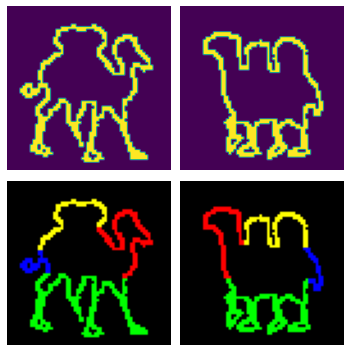

In [9]:
#plot labeled images
fig, ax = plt.subplots(2,2,figsize=(5,5))
for i in range(2):
    ax[0,i].imshow(camels[i])
    ax[0,i].axis("off")
    ax[1,i].imshow(c_camels[i])
    ax[1,i].axis("off")
plt.tight_layout()
plt.show()

In [10]:
pix = 64

In [11]:
#Fix mm-space of barycenter as grid (64,64)
Y,M_Y,mu_Y = mm_from_img(np.ones((pix,pix)),norm_grid=False)
max_dist = np.linalg.norm([pix-1,pix-1]) #maximum distance in grid
print(np.shape(M_Y))

(4096, 4096)


In [12]:
#Create labelspace of size 4 [0,1,2,3]
labels_Y = [np.ones(len(Y))*i for i in range(4)]

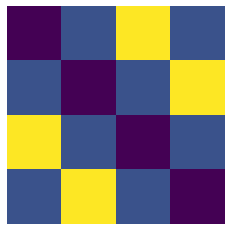

In [13]:
#label_dists (squared euclidean distances)
label_dists = np.zeros((4,4))
label_dists[0,1] = 1
label_dists[0,2] = 4
label_dists[0,3] = 1
label_dists[1,2] = 1
label_dists[1,3] = 4
label_dists[2,3] = 1
label_dists += label_dists.T

plt.imshow(label_dists)
plt.axis("off")
plt.show()

In [14]:
#OT costs from mm[0] to Y x A (saved as (4,len(mm[0],4096) matrix)
ot_cost_1 = [np.zeros((len(mms[0][0]),len(Y))) for l in range(4)]
for l in range(4):
    for i in range(len(mms[0][0])):
        for j in range(len(Y)):
            ot_cost_1[l][i,j] = label_dists[L[0][i],int(labels_Y[l][j])]
ot_cost_1 = np.array(ot_cost_1)

In [15]:
#OT costs from Y x A to mm[1]
ot_cost_2 = [np.zeros((len(Y),len(mms[1][0]))) for l in range(4)]
for l in range(4):
    for j in range(len(Y)):
        for i in range(len(mms[1][0])):
            ot_cost_2[l][j,i] = label_dists[L[1][i],int(labels_Y[l][j])]
ot_cost_2 = np.array(ot_cost_2)

In [16]:
#normalize
ot_cost_1 /= 4
ot_cost_2 /= 4

In [17]:
#function to initialize a tree (mm[0] <-> Y <-> mm[1]) with the respective paremeters 
def create_tree(t,rho):
    r = anytree.AnyNode(id=0)
    n1 = anytree.AnyNode(id=1,parent=r)
    n2 = anytree.AnyNode(id=2,parent=n1)

    r.t = None
    n1.t = t
    n2.t = 1-t

    forward = [node for node in anytree.PreOrderIter(r)]

    r.mu = mms[0][2]
    r.M = mms[0][1] / max_dist
    r.pi = None
    r.cost = None
    r.rho = rho
    r.n_labels = 4

    #barycenter
    n1.rho = 0
    n1.M = M_Y / max_dist
    n1.n_labels = 4
    n1.ot_cost = ot_cost_1

    n2.mu = mms[1][2]
    n2.M = mms[1][1] / max_dist
    n2.rho = rho
    n2.ot_cost = ot_cost_2
    n2.n_labels = 4
    return r

In [18]:
#GW
rho = np.inf
alph = 1
t = 0.5
r = create_tree(t,rho)
result = MUGW_fused2(r,eps= 0.00007,rho=None,alph=alph,plan_cvgce_thres=1e-5,max_iter = 10000,sink_cvgce_thres=1e-6,n_its_check_cvgce=5,n_its = 100,img1 = camels[0], img2 = camels[1],plot_intermediate=False)
tmps = [np.sum(r.children[0].pi[l],axis=0).reshape((64,64)) for l in range(4)]
gw_plans_2 = [r.children[0].pi,r.children[0].children[0].pi]
gw_barys_2 = tmps

Terminated after 36 iterations with last update 4.73939072089954e-06.


In [19]:
#FGW
rho = np.inf
alph = 1/2
t = 0.5
r = create_tree(t,rho)
result = MUGW_fused2(r,eps= 0.00007,rho=None,alph=alph,plan_cvgce_thres=1e-5,max_iter = 2000,sink_cvgce_thres=1e-6,n_its_check_cvgce=5,n_its = 100,img1 = camels[0], img2 = camels[1],plot_intermediate=False)
tmps = [np.sum(r.children[0].pi[l],axis=0).reshape((64,64)) for l in range(4)]
fgw_plans_2 = [r.children[0].pi,r.children[0].children[0].pi]
fgw_barys_2 = tmps

Terminated after 31 iterations with last update 9.845437343972477e-06.


In [20]:
#UFGW
rho = 0.01
alph = 1/2
t = 0.5
r = create_tree(t,rho)
result = MUGW_fused2(r,eps= 0.00007,rho=None,alph=alph,plan_cvgce_thres=1e-5,max_iter = 1000,sink_cvgce_thres=1e-6,n_its_check_cvgce=5,n_its = 100,img1 = camels[0], img2 = camels[1],plot_intermediate=False)
tmps = [np.sum(r.children[0].pi[l],axis=0).reshape((64,64)) for l in range(4)]
ufgw_plans_2 = [r.children[0].pi,r.children[0].children[0].pi]
ufgw_barys_2 = tmps

Terminated after 36 iterations with last update 1.5441877724736198e-06.


In [21]:
#UGW
rho = 0.01
alph = 1
t = 0.5
r = create_tree(t,rho)
result = MUGW_fused2(r,eps= 0.00007,rho=None,alph=alph,plan_cvgce_thres=1e-5,max_iter = 10000,sink_cvgce_thres=1e-6,n_its_check_cvgce=5,n_its = 100,img1 = camels[0], img2 = camels[1],plot_intermediate=False)
tmps = [np.sum(r.children[0].pi[l],axis=0).reshape((64,64)) for l in range(4)]
ugw_plans_2 = [r.children[0].pi,r.children[0].children[0].pi]
ugw_barys_2 = tmps

Terminated after 46 iterations with last update 5.288114366572169e-06.


In [22]:
tmp_img,bary_col_gw_1 = vis_gw_plan(c_camels[0],mms[0][0],Y,np.sum(gw_barys_2,axis=0).flatten(),np.sum(gw_plans_2[0],axis=0),return_img=True,plot_img=False,sub_box=True,img1_given =True)
tmp_img2,bary_col_gw_2 = vis_gw_plan(c_camels[1],mms[1][0],Y,np.sum(gw_barys_2,axis=0).flatten(),np.sum(gw_plans_2[1],axis=0).T,return_img=True,plot_img=False,sub_box=True,img1_given =True)

tmp_img,bary_col_ugw_1 = vis_gw_plan(c_camels[0],mms[0][0],Y,np.sum(ugw_barys_2,axis=0).flatten(),np.sum(ugw_plans_2[0],axis=0),return_img=True,plot_img=False,sub_box=True,img1_given =True)
tmp_img2,bary_col_ugw_2 = vis_gw_plan(c_camels[1],mms[1][0],Y,np.sum(ugw_barys_2,axis=0).flatten(),np.sum(ugw_plans_2[1],axis=0).T,return_img=True,plot_img=False,sub_box=True,img1_given =True)

tmp_img,bary_col_fgw_1 = vis_gw_plan(c_camels[0],mms[0][0],Y,np.sum(fgw_barys_2,axis=0).flatten(),np.sum(fgw_plans_2[0],axis=0),return_img=True,plot_img=False,sub_box=True,img1_given =True)
tmp_img2,bary_col_fgw_2 = vis_gw_plan(c_camels[1],mms[1][0],Y,np.sum(fgw_barys_2,axis=0).flatten(),np.sum(fgw_plans_2[1],axis=0).T,return_img=True,plot_img=False,sub_box=True,img1_given =True)

tmp_img,bary_col_ufgw_1 = vis_gw_plan(c_camels[0],mms[0][0],Y,np.sum(ufgw_barys_2,axis=0).flatten(),np.sum(ufgw_plans_2[0],axis=0),return_img=True,plot_img=False,sub_box=True,img1_given =True)
tmp_img2,bary_col_ufgw_2 = vis_gw_plan(c_camels[1],mms[1][0],Y,np.sum(ufgw_barys_2,axis=0).flatten(),np.sum(ufgw_plans_2[1],axis=0).T,return_img=True,plot_img=False,sub_box=True,img1_given =True)

In [23]:
bary_col_gw = np.mean([bary_col_gw_1,bary_col_gw_2],axis=0)
bary_col_gw[np.sum(gw_barys_2,axis=0) < 0.0004] = [0,0,0] 

bary_col_fgw = np.mean([bary_col_fgw_1,bary_col_fgw_2],axis=0)
bary_col_fgw[np.sum(fgw_barys_2,axis=0) < 0.0004] = [0,0,0] 

bary_col_ugw = np.mean([bary_col_ugw_1,bary_col_ugw_2],axis=0)
bary_col_ugw[np.sum(ugw_barys_2,axis=0) < 0.0004] = [0,0,0] 

bary_col_ufgw = np.mean([bary_col_ufgw_1,bary_col_ufgw_2],axis=0)
bary_col_ufgw[np.sum(ufgw_barys_2,axis=0) < 0.0004] = [0,0,0] 

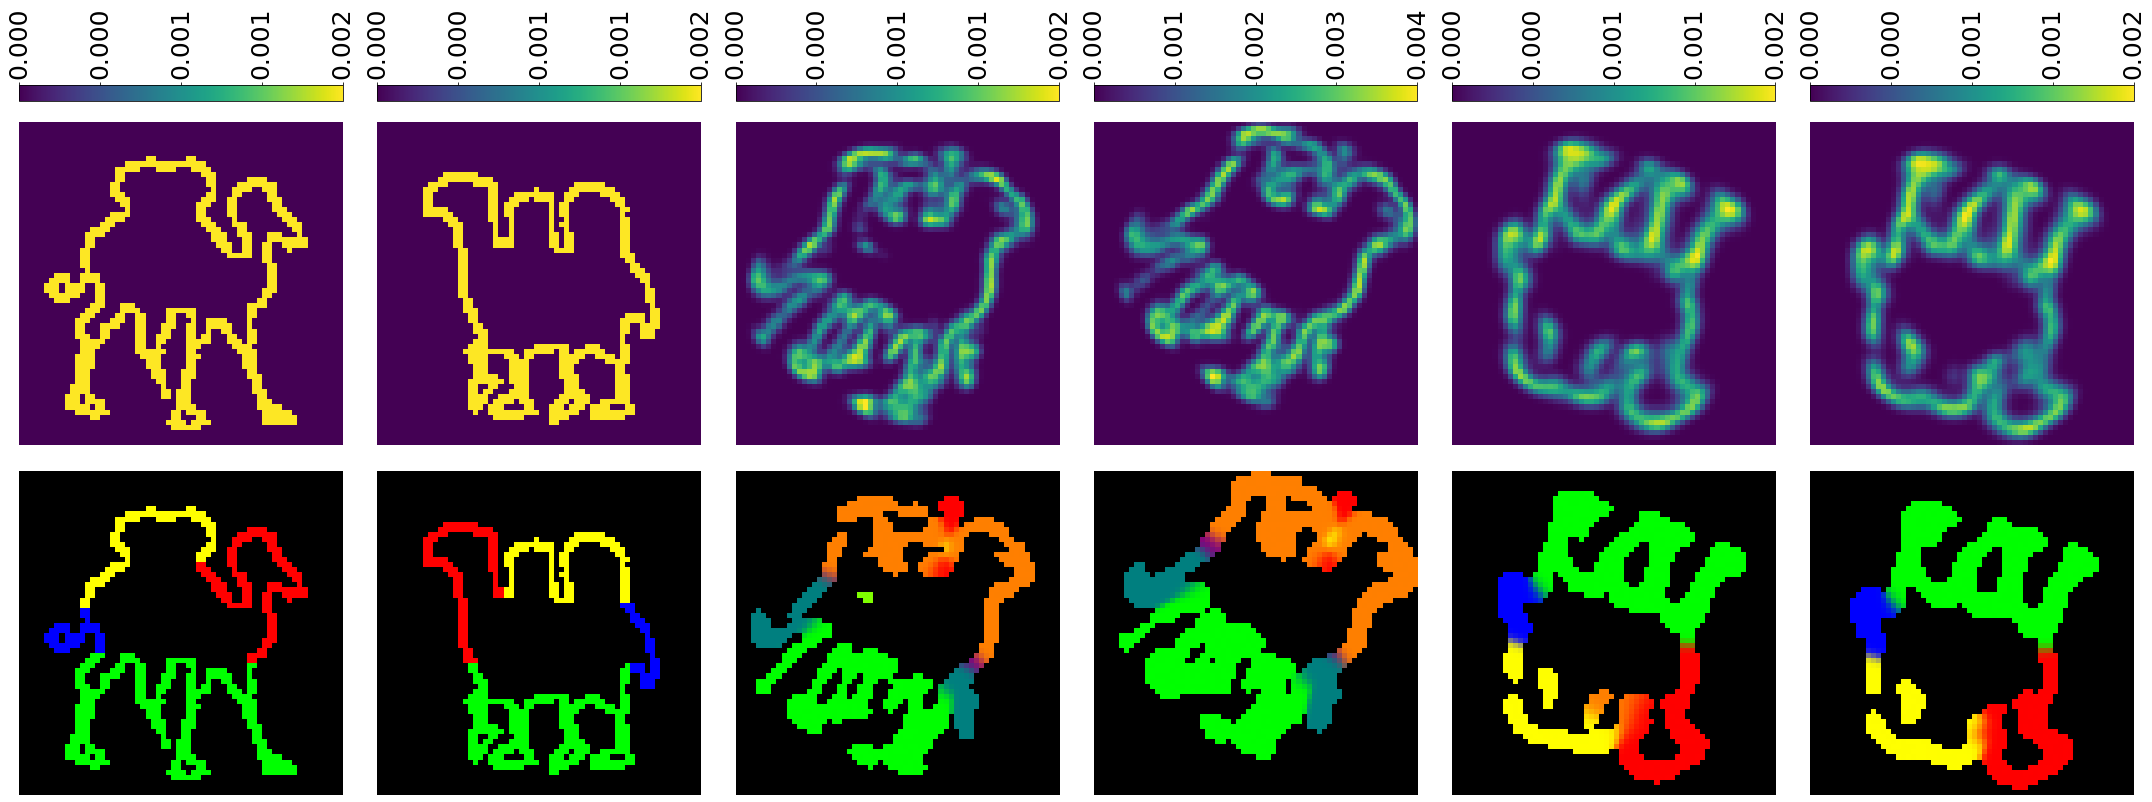

In [24]:
fig, ax = plt.subplots(2,6,figsize=(30,12))

labelsize = 25

for i in range(2):
    im = ax[0,i].imshow(camels[i]/np.sum(camels[i]))
    ax[0,i].axis("off")
    
    ticks = (np.arange(5)/4)*np.max(camels[i]/np.sum(camels[i]))
    cb = plt.colorbar(im,ax=ax[0,i],orientation="horizontal",location="top",ticks = ticks,format="%.3f")
    cb.ax.tick_params(labelsize=labelsize,labelrotation = 90)
    
    ax[1,i].imshow(c_camels[i])
    ax[1,i].axis("off")

barys = [np.sum(gw_barys_2,axis=0),np.sum(ugw_barys_2,axis=0),np.sum(fgw_barys_2,axis=0),np.sum(ufgw_barys_2,axis=0)]
barys_col = [bary_col_gw,bary_col_ugw,bary_col_fgw,bary_col_ufgw]
for i in range(2,6):
    im =ax[0,i].imshow(barys[i-2])
    ax[0,i].axis("off")
    
    ticks = (np.arange(5)/4)*np.max(barys[i-2])
    cb = plt.colorbar(im,ax=ax[0,i],orientation="horizontal",location="top",ticks = ticks,format="%.3f")
    cb.ax.tick_params(labelsize=labelsize,labelrotation = 90)
    
    ax[1,i].imshow(barys_col[i-2])
    ax[1,i].axis("off")

plt.tight_layout()
plt.show()
